<a href="https://colab.research.google.com/github/MattIzon/16010269_DataAnalytics/blob/main/3_Crime_Aquisition_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set-up
from google.colab import auth, files
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
import pandas as pd
pd.set_option('display.max_columns', None)

Authenticated


In [2]:
# Use big query to get the crime data
client = bigquery.Client(project='assignment-305921')

crime = []

for year in range(2015, 2020):
  crime.append(client.query('''
  SELECT date, beat, district, ward, community_area, latitude, longitude, location
  FROM `bigquery-public-data.chicago_crime.crime`
  WHERE year = {}
  ORDER BY date
  '''.format(year)).to_dataframe())

In [3]:
# Check for missing data
index = 0
for year in crime:
  print('Missing Data ', 2015 + index, ':')
  for column in year:
    print('  ', column, ': ', year[column].isna().any())
  index += 1
  print()

Missing Data  2015 :
   date :  False
   beat :  False
   district :  False
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2016 :
   date :  False
   beat :  False
   district :  False
   ward :  False
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2017 :
   date :  False
   beat :  False
   district :  True
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2018 :
   date :  False
   beat :  False
   district :  False
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2019 :
   date :  False
   beat :  False
   district :  False
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True





*   district (2017), ward (2015/2017/2018/2019), latitude, longitude and location have missing data

*   district and ward are linked

*   latitude, longitude and location are linked

In [4]:
# Inspect missing data
index = 0
for year in crime:
  print(2015 + index, ':')
  total_rows = year.shape[0]
  print('Total rows: ', total_rows)
  missing_columns = ['district', 'ward', 'community_area', 'latitude', 'longitude', 'location']
  for column in missing_columns:
    missing_count = sum(year[column].isna())
    print(column, ' missing count: ', missing_count, ' - Percentage of total: ', (missing_count/total_rows)*100)
  index += 1
  print()

2015 :
Total rows:  264679
district  missing count:  0  - Percentage of total:  0.0
ward  missing count:  2  - Percentage of total:  0.00075563229421299
community_area  missing count:  0  - Percentage of total:  0.0
latitude  missing count:  6759  - Percentage of total:  2.5536593382927997
longitude  missing count:  6759  - Percentage of total:  2.5536593382927997
location  missing count:  6759  - Percentage of total:  2.5536593382927997

2016 :
Total rows:  269730
district  missing count:  0  - Percentage of total:  0.0
ward  missing count:  0  - Percentage of total:  0.0
community_area  missing count:  0  - Percentage of total:  0.0
latitude  missing count:  2471  - Percentage of total:  0.9161012864716569
longitude  missing count:  2471  - Percentage of total:  0.9161012864716569
location  missing count:  2471  - Percentage of total:  0.9161012864716569

2017 :
Total rows:  268963
district  missing count:  1  - Percentage of total:  0.0003717983514461097
ward  missing count:  1  - P

*   latitude, longitude and location have equal numbers of missing data. If the missing items are all in the same rows the location column is not required.

*   Potentially district, ward and community_area can be patched using each other's values. Further inspection to determine their usefulness should be completed first.

In [5]:
# Check if latitude, longitude and location's missing data are all in the same rows.
index = 0
for year in crime:
  print(sum(year['latitude'].isna() & year['longitude'].isna() & year['location'].isna()))
  index += 1
  print()

6759

2471

4016

5169

1939



* Figures match for each year, therefore all missing from the same row. Location column can be dropped.

In [6]:
# Drop the location field
no_use = ['location']
for year in crime:
  year.drop(no_use, axis=1, inplace=True)

In [7]:
crime[0].head()

,date,beat,district,ward,community_area,latitude,longitude
0,2015-01-01 01:00:00+00:00,1432,14,32.0,22,41.917743,-87.678366
1,2015-01-01 01:00:00+00:00,1112,11,27.0,23,41.896226,-87.718776
2,2015-01-01 01:00:00+00:00,915,9,11.0,60,41.834670,-87.646199
3,2015-01-01 01:00:00+00:00,2431,24,49.0,1,42.005379,-87.670271
4,2015-01-01 01:00:00+00:00,1222,12,28.0,27,41.882807,-87.705031


In [8]:
# Inspect beat, district, ward, community_area
index = 0
for year in crime:
  print(2015 + index, ':')
  columns = ['beat', 'district', 'ward', 'community_area']
  for column in columns:
    unique_count = year[column].nunique()
    print(column, ' unique count: ', unique_count)
  index += 1
  print()

2015 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2016 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2017 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2018 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2019 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77



* Identical figures for each year suggest these are the total numbers of each beat, district, ward and community_area

* beat has the largest number of unique values (274) and so must be the narrowest area.
As the smallest area, the average latitude / longitude per beat is the best solution available to fill the missing data in those columns.

* district has the lowest number of unique values (23) and so must be the widest area.
This could be useful for the DNN, however the missing row in 2017 will need addressing 

In [9]:
# Fill missing latitude / longitude data
for year in crime:
  beats = year['beat'].unique().tolist()

  for beat in beats:
    year.loc[(year['beat'] == beat) & (year['latitude'].isnull()), 'latitude'] = year[year['beat'] == beat]['latitude'].mean(axis = 0, skipna = True)
    year.loc[(year['beat'] == beat) & (year['longitude'].isnull()), 'longitude'] = year[year['beat'] == beat]['longitude'].mean(axis = 0, skipna = True)

In [10]:
# Fill missing district in 2017
ward = crime[2].loc[crime[2]['district'].isnull(), 'ward'].values[0]
district = crime[2].loc[crime[2]['ward'] == ward]['district'].mode().values[0]
crime[2].loc[crime[2]['district'].isnull(), 'district'] = district

In [11]:
# Convert the datetime to date column
for year in crime:
  year['date'] = pd.to_datetime(year['date']).dt.date

In [12]:
# Add day_of_week column containing the day of the week: Monday 1 ... Sunday 7
jan_01 = [4, 5, 7, 1, 2]

def get_date_day(date_str):
  return date_str[8:]

for year in range(len(jan_01)):
  curr_date_day = '01'
  curr_d_o_w = jan_01[year]
  d_o_w = []

  for date_str in crime[year]['date']:
    date_day = get_date_day(date_str.strftime('%Y-%m-%d'))
    if date_day != curr_date_day:
      curr_date_day = date_day
      curr_d_o_w += 1
      if curr_d_o_w == 8:
        curr_d_o_w = 1
    d_o_w.append(curr_d_o_w)
  crime[year]['day_of_week'] = d_o_w

In [13]:
# Calculate the closest of the three chosen weather stations and append a column containing the station's usaf

import math

def distance(a, b):
  x_component = (b[0] - a[0]) ** 2
  y_component = (b[1] - a[1]) ** 2
  return math.sqrt(x_component + y_component)

stations = {'stn': [722126, 725300, 725340],
            'lat': [41.54, 41.96, 41.786],
            'lon': [-87.532, -87.932, -87.752]}

for year in crime:
  stns = []
  for row in year.itertuples(False, None):
    min_distance = 999
    nearest_stn = None
    a = [row[5], row[6]]
    for index in range(len(stations)):
      b = [stations['lat'][index], stations['lon'][index]]
      distance_ab = distance(a, b)
      if distance_ab < min_distance:
        min_distance = distance_ab
        nearest_stn = stations['stn'][index]
    stns.append(nearest_stn)
  year['station'] = stns

In [14]:
for year in crime:
  year['total_crimes'] = year.date.map(year.date.value_counts())

In [15]:
# Drop the remaining unnecessary fields
no_use = ['beat', 'ward', 'community_area', 'latitude', 'longitude']
for year in crime:
  year.drop(no_use, axis=1, inplace=True)

In [17]:
crime[0].head(2)

,date,district,day_of_week,station,total_crimes
0,2015-01-01,14,4,725340,1241
1,2015-01-01,11,4,725340,1241


In [29]:
# Count crimes per day in each district

districts = []
for year in crime:
  districts.append(year.groupby(['date', 'day_of_week','district'])['date'].count().reset_index(name='crime_count'))


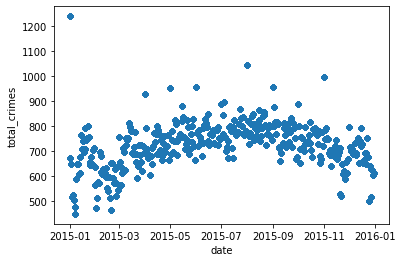

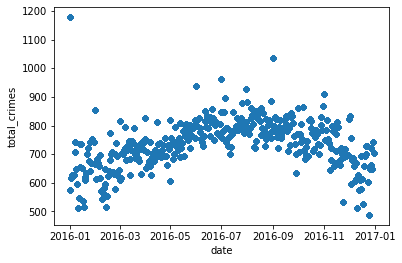

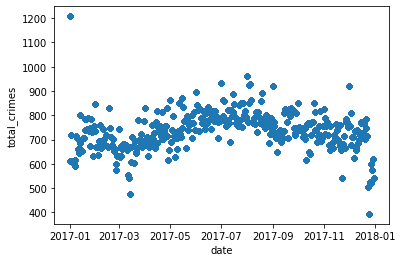

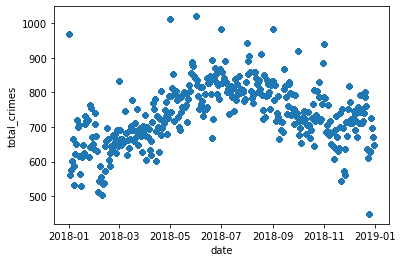

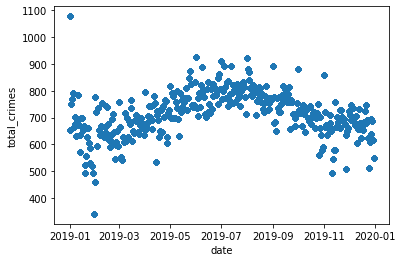

In [ ]:
for year in crime:
  year.plot(x = 'date', y = 'total_crimes', kind = 'scatter')

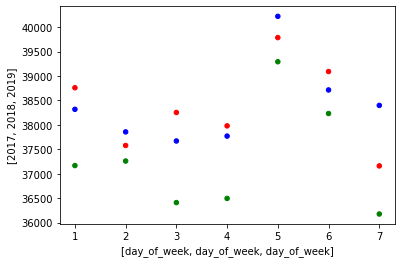

In [ ]:
day__num_crimes = pd.DataFrame({
    'day_of_week': crime[1]['day_of_week'].drop_duplicates().sort_values(),
    # '2016': crime[0]['day_of_year'].value_counts().sort_index(ascending=True).tolist(),
    '2017': crime[1]['day_of_week'].value_counts().sort_index(ascending=True).tolist(),
    '2018': crime[2]['day_of_week'].value_counts().sort_index(ascending=True).tolist(),
    '2019': crime[3]['day_of_week'].value_counts().sort_index(ascending=True).tolist(),
    # '2020': crime[4]['day_of_year'].value_counts().sort_index(ascending=True).tolist()
})
day__num_crimes.plot.scatter(x = ['day_of_week', 'day_of_week', 'day_of_week'], y = [ '2017', '2018', '2019',], c = ['blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green',])

In [ ]:
# Save crime data to CSV files.

names = ['c_2015', 'c_2016', 'c_2017', 'c_2018', 'c_2019']

# for index in range(len(names)):
#   with open('/gdrive/My Drive/assignment/data/crime/{}.csv'.format(names[index]), 'w') as f:
#     crime[index].to_csv(f)

for index in range(len(names)):
  crime[index].to_csv('{}.csv'.format(names[index])) 
  files.download('{}.csv'.format(names[index]))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>